# 1. Đọc dataframe

In [129]:
df = df[['id', 'authors', 'source_domain', 'language', 'title', 'description', 'maintext', 'target']]
df.reset_index(drop=True, inplace=True)
df.head()

,id,authors,source_domain,language,title,description,maintext,target
0,Fake_0,,2sao.vn,vi,Con gái chính là người tình kiếp trước của cha...,Tình phụ tử: Cách yêu thương của cha giành cho...,"Thế nhưng, dù không nói ra thì cha vĩnh viễn l...",Fake
1,Fake_1,Văn Trình,binhluan.biz,en,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,,"Theo Sankei Sports, sáng nay Thủ tướng Nhật Bả...",Fake
2,Fake_10,,suckhoe.vnexpress.net,vi,Bức vẽ giúp bạn đánh giá mức độ stress của bản...,Bức vẽ gồm một hình cầu dường như đang trượt m...,"Nhìn bức tranh, bạn có thể thấy vòng tròn đang...",Fake
3,Fake_100,,www.vietgiaitri.com,vi,YÊU RÂU XANH (P51): Câu chuyện động trời sau t...,"Đúng lúc đó, một người hàng xóm nhà bà H sang ...","Sau khi vụ án xảy ra, tất cả mọi người đều khô...",Fake
4,Fake_101,,mangxahoi.net,vi,"NÓNG : xử phạt 10 đối tượng ""bom"" hàng "" Lợi d...",,"ĐANG RẤT QUÁ TẢI, MONG MỌI NGƯỜI Ý THỨC! NGƯỜI...",Fake


In [130]:
df.shape

(259, 8)

# 2. Tiền xử lí dữ liệu

In [131]:
df.describe()

,id,authors,source_domain,language,title,description,maintext,target
count,259,259,259,259,259,259,259,259
unique,259,32,54,3,258,226,259,2
top,Fake_0,,vnexpress.net,vi,MC Lại Văn Sâm đột ngột qua đời ở tuổi 64,,"Thế nhưng, dù không nói ra thì cha vĩnh viễn l...",Fake
freq,1,208,74,232,2,34,1,131


The feature `Language` has 3 values (vi, en, empty) in comparision with others, so it doesn't play any crucial role in the Decision tree (at section Rule-based systen) below.

In [132]:
# Check for duplicates
df[df.duplicated(subset=df.columns.difference(['id']), keep=False)]


,id,authors,source_domain,language,title,description,maintext,target


In [133]:
df.drop(index=105, inplace=True)  # Drop the row with index 105
df.reset_index(drop=True, inplace=True) 


In [134]:
# Check for imbalance. Fake and Real values are nearly equal, so no resampling is needed
df['target'].value_counts()  


target
Fake    130
Real    128
Name: count, dtype: int64

# 3. Tìm rule-based system 

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a Decision Tree with entropy as the criterion
def model_tree(depth):
    model = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42) 
    return model


# Measure an accuracy for Decision tree
def calculate_acc(dataframe, x_features, y_feature, model=model_tree):    
    X = x_features 
    y = dataframe[y_feature].values

    # Take 80% dataset for training, 20% for testing model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

    # Training model
    model.fit(X_train, y_train)

    # Calculate accuracy after training the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return f"Accuracy of Decision Tree: {accuracy:.2%}"


# Create a tree plot
def plot_decision_tree(model, x_features):
    plt.figure(figsize=(12, 8))
    plot_tree(model, feature_names=x_features, class_names=["Fake", "Real"], filled=True)
    plt.show()


## 3.1 Tìm RB dựa trên `source_domain` và `authors`

In [136]:
df1 = df[['authors', 'source_domain', 'target']]
df1.shape


(258, 3)

In [137]:
# Encode source_domain and authors using LabelEncoder
from sklearn.preprocessing import LabelEncoder

encoder_source = LabelEncoder()
encoder_authors = LabelEncoder()

df1["source_domain_encoded"] = encoder_source.fit_transform(df1["source_domain"])
df1["authors_encoded"] = encoder_authors.fit_transform(df1["authors"])


C:\Users\nttm\AppData\Local\Temp\ipykernel_25460\623145169.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["source_domain_encoded"] = encoder_source.fit_transform(df1["source_domain"])
C:\Users\nttm\AppData\Local\Temp\ipykernel_25460\623145169.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["authors_encoded"] = encoder_authors.fit_transform(df1["authors"])


Accuracy of Decision Tree: 90.38%


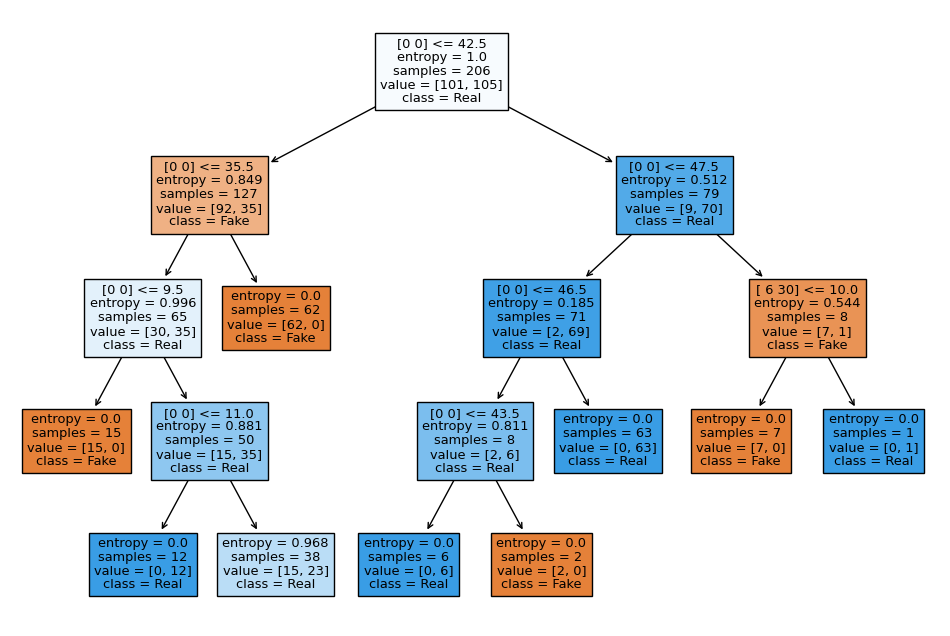

None


In [138]:
tree_model1 = model_tree(depth=4)

X_le = np.hstack([df1["source_domain_encoded"].values.reshape(-1, 1),
                  df1["authors_encoded"].values.reshape(-1, 1)])

print(calculate_acc(df1, X_le, 'target', model=tree_model1))
print(plot_decision_tree(tree_model1, X_le))


In [139]:
# Create a mapping table for source_domain
df_mapping_source = pd.DataFrame({"source_domain_encoded": df1["source_domain_encoded"],
                                  "source_domain_original": df["source_domain"]}
                                  ).drop_duplicates().sort_values(by="source_domain_encoded", ascending=True)
df_mapping_source


,source_domain_encoded,source_domain_original
0,0,2sao.vn
5,1,anninh247.xyz
35,2,autoxe.net
43,3,baoangiang.com.vn
52,4,baonuocmy.com
11,5,baophapluat.online
1,6,binhluan.biz
29,7,blogxcy.wordpress.com
6,8,cand.com.vn
36,9,congtintuc24gio.com


In [140]:
# Save the mapping table for source_domain as a txt file
with open("mapping_source.txt", "w") as f:
    f.write(df_mapping_source.to_string(index=False))


In [141]:
df[df['source_domain'].str.contains('giadinhtiepthi.com', case=False, na=False)]


,id,authors,source_domain,language,title,description,maintext,target
88,Fake_6,Please Enter Your Name Here,giadinhtiepthi.com,vi,"Cười vỡ bụng khi tiếng CẢI CÁCH ""vuông tròn"" x...",,"Những ngày qua, các phụ huynh liên tục chia sẻ...",Fake
99,Fake_7,Please Enter Your Name Here,giadinhtiepthi.com,vi,Chia sẻ thẳng thắn vụ việc 25000 USD và cải cá...,,"Những ngày qua, trên mạng xã hội các phụ huynh...",Fake


In [142]:
# Create a mapping table for authors
df_mapping_authors = pd.DataFrame({"authors_encoded": df1["authors_encoded"], 
                                   "authors_original": df["authors"]}
                                   ).drop_duplicates().sort_values(by="authors_encoded", ascending=True)
df_mapping_authors


,authors_encoded,authors_original
0,0,
170,1,An Bình
172,2,CÔNG TRUNG
42,3,Cùng Tác Giả
44,4,"Cùng Tác Giả, Nguyễn Thiện"
171,5,D.KIM THOA
77,6,Gioi Tre Viet
181,7,Hiếu Công
40,8,"Hoàng Vy Thế Giới Trẻ, - Phuong Thao -, - Dung..."
131,9,Hạ Huyền


In [143]:
# Save the mapping table for authors as a txt file
with open("mapping_authors.txt", "w", encoding="utf-8") as f:
    f.write(df_mapping_authors.to_string(index=False))

## 3.2 Tìm RB dựa trên `title`

In [144]:
df2 = df[['title', 'target']]
df2.shape


(258, 2)

In [145]:
# Load n-grams from a file
def read_ngrams(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f.readlines()]

# Read the n-gram list from three files
dictionaries_path = os.path.join(os.getcwd(), "dictionaries")
bi_grams = read_ngrams(os.path.join(dictionaries_path, "bi_gram.txt"))
tri_grams = read_ngrams(os.path.join(dictionaries_path, "tri_gram.txt"))
four_grams = read_ngrams(os.path.join(dictionaries_path, "four_gram.txt"))

# Compile a list of all n-gram
all_ngrams = set(bi_grams + tri_grams + four_grams)

print("The number of n-grams:", len(all_ngrams))


The number of n-grams: 44800


In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract title data
titles = df2["title"].astype(str).tolist()

# Initialize TfidfVectorizer with an n-grams list from the file
vectorizer = TfidfVectorizer(ngram_range=(2, 4), vocabulary=all_ngrams)

# Calculate TF-IDF
X_tfidf = vectorizer.fit_transform(titles)

# Get the list of feature words
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = np.array(X_tfidf.mean(axis=0)).flatten()

# Convert to DataFrame and sort TF-IDF weights in descending order
df2_tfidf = pd.DataFrame({'N-gram': feature_names, 'TF-IDF Score': tfidf_scores}).sort_values(by="TF-IDF Score", ascending=False)

df2_tfidf.head(12)


c:\Users\nttm\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:1380: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


,N-gram,TF-IDF Score
41715,đàn ông,0.020724
29536,sự thật,0.019443
19809,máy bay,0.015892
6173,con gái,0.014543
25289,phát hiện,0.013500
35330,tài xế,0.013108
7047,có thể,0.012707
39717,xã hội,0.012634
1684,báo mộng,0.011828
16058,kinh hoàng,0.010445


In [147]:
# Select the top 10 n-grams with the highest weights
top_ngrams = df2_tfidf.nlargest(300, 'TF-IDF Score')["N-gram"].tolist()


# Create a feature matrix from df2['title']
vectorizer_top = TfidfVectorizer(ngram_range=(2, 4), vocabulary=top_ngrams)
# Vector the data
X_tfidf_top = vectorizer_top.fit_transform(df2["title"]).toarray()


tree_model2 = model_tree(depth=50)
print(calculate_acc(df2, X_tfidf_top, 'target', model=tree_model2))
# print(plot_decision_tree(tree_model2, vectorizer_top.get_feature_names_out()))

feature_names = vectorizer_top.get_feature_names_out().tolist()
print(export_text(tree_model2, feature_names=feature_names))
# print(export_text(tree_model2, feature_names=vectorizer_top.get_feature_names_out()))

Accuracy of Decision Tree: 71.15%
|--- sự thật <= 0.17
|   |--- con gái <= 0.22
|   |   |--- kinh dị <= 0.25
|   |   |   |--- tài xế <= 0.24
|   |   |   |   |--- bí mật <= 0.25
|   |   |   |   |   |--- báo mộng <= 0.21
|   |   |   |   |   |   |--- đàn ông <= 0.43
|   |   |   |   |   |   |   |--- cải cách <= 0.28
|   |   |   |   |   |   |   |   |--- lý do <= 0.26
|   |   |   |   |   |   |   |   |   |--- tất cả <= 0.18
|   |   |   |   |   |   |   |   |   |   |--- thủ tướng <= 0.25
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 40
|   |   |   |   |   |   |   |   |   |   |--- thủ tướng >  0.25
|   |   |   |   |   |   |   |   |   |   |   |--- class: Fake
|   |   |   |   |   |   |   |   |   |--- tất cả >  0.18
|   |   |   |   |   |   |   |   |   |   |--- class: Fake
|   |   |   |   |   |   |   |   |--- lý do >  0.26
|   |   |   |   |   |   |   |   |   |--- class: Fake
|   |   |   |   |   |   |   |--- cải cách >  0.28
|   |   |   |   |   |   |   |   |--- class: Fak

# 4. Tổng hợp rule-based system

In [148]:
import string
import math  

def rule_based_classification(source, author, text_title):
    # List of fake news sources
    fake_sources = {
        '2sao.vn', 'anninh247.xyz', 'autoxe.net', 'baoangiang.com.vn', 'baonuocmy.com', 
        'baophapluat.online', 'binhluan.biz', 'blogxcy.wordpress.com', 'cand.com.vn', 'congtintuc24gio.com',
        'thoibao.de', 'thoibao.today', 'tingame.info', 'tintuconline.com.vn', 'tintucqpvn.net', 
        'tinvn.info', 'trumpandq.blogspot.com', 'tuvanannam.com', 'vietgiaitri.com', 'vinaexpress.com.vn'}

    # List of suspicious authors
    fake_author_keywords = {'An Bình', 'CÔNG TRUNG', 'Cùng Tác Giả', 'D.KIM THOA', 'Gioi Tre Viet',
                            'Hiếu Công', 'Hoàng Vy Thế Giới Trẻ', 'Hạ Huyền', 'J', 'Daisy'}
  
    # Keywords and TF-IDF threshold: Above this means fake
    keywords = {'sự thật': 0.17,
                'con gái': 0.22,
                'kinh dị': 0.25,
                'tài xế': 0.24,
                'bí mật': 0.25,
                'đàn ông': 0.43,
                'tất cả': 0.18,
                'báo mộng': 0.25,
                'lý do': 0.26,
                'cải cách': 0.28,
                'cảnh tượng': 0.20}
    
    # List of punctuation marks to check (excluding period . and comma ,)
    punctuation_to_check = set(string.punctuation) - {'.', ','}
    
    # Rule 1: Determine the Fake ratio based on source and author
    fake_source = source in fake_sources
    fake_author = any(keyword in author for keyword in fake_author_keywords) 

    if fake_source and fake_author:
        fake_score_source_author = 1 * 0.9  # Fake both source and author
    elif fake_source:
        fake_score_source_author = 5/6 * 0.9  # Fake the source as 5/6 leaf nodes predict source_domain
    elif fake_author:
        fake_score_source_author = 1/6 * 0.9  # Fake the author as 1/6 leaf nodes predict authors
    else:
        fake_score_source_author = 0  # No Fake in both
    
    # Rule 2: Calculate TF-IDF to check keywords in title
    vectorizer = TfidfVectorizer(vocabulary=keywords.keys()) 
    tfidf_matrix = vectorizer.fit_transform([text_title])
    
    fake_score_keywords = 0
    count_violations = 0
    
    feature_names = vectorizer.get_feature_names_out()
    for idx, word in enumerate(feature_names):
        if tfidf_matrix[0, idx] > keywords[word]:  
            count_violations += 1  

    # Check punctuation directly in text_title
    count_punctuation_violations = sum(1 for p in punctuation_to_check if p in text_title)
    count_violations += count_punctuation_violations 
    
    # Calculate the Fake score based on the number of violations
    if count_violations > 0:
        fake_score_keywords = 1 - math.pow(0.75, count_violations) 
    
    # Calculate the Fake/Real ratio from source/author and keywords
    fake_score = (fake_score_source_author * 0.9/0.75 + fake_score_keywords * 0.75/0.9) / 2
    real_score =  1 - fake_score

    return {'fake_score':round(fake_score, 2), 'real_score': round(real_score, 2) }


In [149]:
# Re-test with an example 
source = 'thoibao.today'
author = ''
text_title = 'Khám phá sửng sốt về trí nhớ /"như thần/" của động vật' 

result = rule_based_classification(source, author, text_title)
result
# result['fake_score']  # Chỉ in Fake_score

{'fake_score': 0.63, 'real_score': 0.37}

# 5. Fine-tune LLM 

Dùng Pho-BERT để huấn luyện bộ tin tức Tiếng Việt

In [150]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "vinai/phobert-base-v2"

# Load tokenizer and model
bert = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 5.1 Encode target

Cho tin tức có target là 'Real', thì sẽ được encode giá trị 0. Còn 'Fake' thì là 1.

In [151]:
def encode_target(target):
    return 1 if target == "Fake" else 0

# Apply function to create fake_score column
df["target_fake"] = df["target"].apply(encode_target)

In [152]:
df.head()

,id,authors,source_domain,language,title,description,maintext,target,target_fake
0,Fake_0,,2sao.vn,vi,Con gái chính là người tình kiếp trước của cha...,Tình phụ tử: Cách yêu thương của cha giành cho...,"Thế nhưng, dù không nói ra thì cha vĩnh viễn l...",Fake,1
1,Fake_1,Văn Trình,binhluan.biz,en,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,,"Theo Sankei Sports, sáng nay Thủ tướng Nhật Bả...",Fake,1
2,Fake_10,,suckhoe.vnexpress.net,vi,Bức vẽ giúp bạn đánh giá mức độ stress của bản...,Bức vẽ gồm một hình cầu dường như đang trượt m...,"Nhìn bức tranh, bạn có thể thấy vòng tròn đang...",Fake,1
3,Fake_100,,www.vietgiaitri.com,vi,YÊU RÂU XANH (P51): Câu chuyện động trời sau t...,"Đúng lúc đó, một người hàng xóm nhà bà H sang ...","Sau khi vụ án xảy ra, tất cả mọi người đều khô...",Fake,1
4,Fake_101,,mangxahoi.net,vi,"NÓNG : xử phạt 10 đối tượng ""bom"" hàng "" Lợi d...",,"ĐANG RẤT QUÁ TẢI, MONG MỌI NGƯỜI Ý THỨC! NGƯỜI...",Fake,1


## 5.2 Chia dataset ra tập train, validation và test

Chia tập dataset Train-Validation-Test theo ratio 70:15:15

In [153]:
# Splitting while keeping all feature columns
train_df, temp_df = train_test_split(
    df, test_size=0.3, random_state=2018, stratify=df['target']
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=2018, stratify=temp_df['target']
)

In [154]:
# Extract only column 'maintext' for training PhoBERT
train_texts = train_df['maintext']
val_texts = val_df['maintext']
test_texts = test_df['maintext']

train_labels = train_df['target_fake']
val_labels = val_df['target_fake']
test_labels = test_df['target_fake']

## 5.3 Tokenize dataset

In [155]:
%pip install torch
import torch

Note: you may need to restart the kernel to use updated packages.


In [156]:
MAX_LENGTH = 218
tokens_train = tokenizer.batch_encode_plus(
    train_texts.tolist(),
    max_length = MAX_LENGTH,
    padding='max_length',
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_texts.tolist(),
    max_length = MAX_LENGTH,
    padding='max_length',
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_texts.tolist(),
    max_length = MAX_LENGTH,
    padding='max_length',
    truncation=True
)

# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

train_labels = torch.tensor(train_labels.tolist()) # Convert to flat tensor
val_labels = torch.tensor(val_labels.tolist())
test_labels = torch.tensor(test_labels.tolist())

train_y = train_y.view(-1, 1)  # Reshape labels to (num_samples, 1)
val_y = val_y.view(-1, 1)
test_y = test_y.view(-1, 1)

## 5.4 Dựng Dataloader

In [157]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

test_data = TensorDataset(test_seq, test_mask, test_y)    # wrap tensors
test_sampler = SequentialSampler(test_data)                     # sampler for sampling the data during training
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## 5.5 Dựng model

Đảm bảo là gradient vẫn sẽ được tính qua các layer

In [158]:
for param in bert.parameters():
    param.requires_grad = True 

In [159]:
import torch
import torch.nn as nn
from torch.optim import AdamW

# Define the PhoBERT-based regression model
class PhoBERTRegressor(nn.Module):
    def __init__(self, bert):
        super(PhoBERTRegressor, self).__init__()
        self.bert = bert
        self.sigmoid = nn.Sigmoid()  # Ensures output is between 0 and 1

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Use logits directly
        return self.sigmoid(logits)  # Apply sigmoid for output in (0,1)

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to the appropriate device
model = PhoBERTRegressor(bert).to(device)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=1e-5)  # Learning rate
loss_fn = nn.MSELoss().to(device)  # Mean Squared Error for regression tasks

# Set number of training epochs
epochs = 2

## 5.6 Dựng training loop

In [160]:
# Define training function
def train():
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):  
        # Progress update every 50 batches
        if step % 50 == 0 and step != 0:
            print(f'  Batch {step:,} of {len(train_dataloader):,}.')

        # Move batch data to device
        sent_id, mask, scores = [t.to(device) for t in batch]
        scores = scores.float()  # Ensure labels are float for regression

        # Clear previous gradients
        model.zero_grad()

        # Forward pass
        preds = model(input_ids=sent_id, attention_mask=mask)

        # Compute loss
        loss = loss_fn(preds, scores)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Prevent exploding gradients
        optimizer.step()

    # Compute average training loss
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


# Define evaluation function
def evaluate():
    print("\nEvaluating...")
    model.eval()  # Set model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for step, batch in enumerate(val_dataloader):
            # Progress update every 50 batches
            if step % 50 == 0 and step != 0:
                print(f'  Batch {step:,} of {len(val_dataloader):,}.')

            # Move batch data to device
            sent_id, mask, scores = [t.to(device) for t in batch]
            scores = scores.float()  # Ensure labels are float for regression

            # Forward pass
            preds = model(sent_id, mask)

            # Compute loss
            loss = loss_fn(preds, scores)
            total_loss += loss.item()

    # Compute average validation loss
    avg_loss = total_loss / len(val_dataloader)
    return avg_loss

## 5.7 Huấn luyện model

In [161]:
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

os.makedirs("results", exist_ok=True) # Create a folder to save model weights

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'results/model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 2

Evaluating...

Training Loss: 0.247
Validation Loss: 0.235

 Epoch 2 / 2

Evaluating...

Training Loss: 0.230
Validation Loss: 0.220


## 5.8 Chạy bộ test data với model

In [162]:
def predict_fake_score(model, tokenizer, text, device):
    model.eval()  # Set model to evaluation mode
    
    # Tokenize the single input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
    
    # Move inputs to the same device as the model
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():  # No gradient calculation needed
        outputs = model(input_ids, attention_mask)
        score = outputs.cpu().numpy().flatten()[0]  # Extract single score

    return score 


In [163]:
# Example usage
text_sample = "This is a sample text to test the model."
predicted_score = predict_fake_score(model, tokenizer, text_sample, device)

predicted_score

0.48763162

# 6. Kết hợp Rule-based và LLM

Kết hợp fake-score của Rule-based và của LLM để cho ra nhận định cuối là tin thật hay giả

In [164]:
test_df.head()

,id,authors,source_domain,language,title,description,maintext,target,target_fake
178,Real_27,,vnexpress.net,vi,Sắp có tuyến buýt '5 sao' từ Tân Sơn Nhất đi V...,"Để kịp phục vụ du khách dịp lễ tết cuối năm, T...",TP HCM muốn có tuyến buýt từ Tân Sơn Nhất đi c...,Real,0
187,Real_35,,vnexpress.net,vi,Nhân viên an ninh sân bay Thọ Xuân bị phạt vì ...,"Khi diễn ra vụ gây rối ở sân bay Thọ Xuân, bốn...",Nhân viên an ninh hàng không Thọ Xuân bị xem x...,Real,0
131,Real_1,Hạ Huyền,https://news.zing.vn,,Tung tin &#39;Mr Bean&#39; qua đời để phát tán...,,"Hôm 19/7, nhiều độc giả cảnh báo nhau trên mạn...",Real,0
172,Real_21,CÔNG TRUNG,tuoitre.vn,,Máy bay Vietjet gặp sự cố ở Buôn Ma Thuột mới ...,,TTO - Chuyến bay số hiệu VJ356 được Vietjet Ai...,Real,0
212,Real_58,,vnexpress.net,vi,Lao động nước ngoài ở Việt Nam phải đóng bảo h...,Công dân nước ngoài làm việc tại Việt Nam nếu ...,Chính phủ vừa ban hành Nghị định quy định chi ...,Real,0


In [165]:
# Create lists to store results
titles, authors, maintexts, sources, y_observeds = [], [], [], [], []
rule_based_scores, llm_scores, final_fake_scores, predictions = [], [], [], []

for title, maintext, author, source, y_observed in zip(test_df['title'], test_df['maintext'], test_df['authors'], test_df['source_domain'], test_df['target']):
    fake_score_from_rule_based = rule_based_classification(source, author, title)['fake_score']
    fake_score_from_llm = predict_fake_score(model, tokenizer, maintext, device)

    # Calculate total fake score
    final_fake_score = (fake_score_from_rule_based + fake_score_from_llm)/2

    # Determine prediction
    y_expected = "Fake" if final_fake_score > 0.5 else "Real"

    # Append results to lists
    titles.append(title)
    authors.append(author)
    maintexts.append(maintext)
    sources.append(source)
    rule_based_scores.append(fake_score_from_rule_based)
    llm_scores.append(fake_score_from_llm)
    final_fake_scores.append(final_fake_score)
    predictions.append(y_expected)
    y_observeds.append(y_observed)
    
# Create new DataFrame
result_df = pd.DataFrame({
    "title": titles,
    "author": authors,
    "maintext": maintexts,
    "source": sources,
    "fake_score_from_rule_based": rule_based_scores,
    "fake_score_from_llm": llm_scores,
    "final_fake_score": final_fake_scores,
    "y_expected": predictions,
    "y_observed": y_observeds
})

# Save DataFrame to CSV
result_df.to_csv("results/fake_news_predictions.csv", index=False)

# Display first few rows
result_df.head(10)

,title,author,maintext,source,fake_score_from_rule_based,fake_score_from_llm,final_fake_score,y_expected,y_observed
0,Sắp có tuyến buýt '5 sao' từ Tân Sơn Nhất đi V...,,TP HCM muốn có tuyến buýt từ Tân Sơn Nhất đi c...,vnexpress.net,0.10,0.447754,0.273877,Real,Real
1,Nhân viên an ninh sân bay Thọ Xuân bị phạt vì ...,,Nhân viên an ninh hàng không Thọ Xuân bị xem x...,vnexpress.net,0.10,0.454382,0.277191,Real,Real
2,Tung tin &#39;Mr Bean&#39; qua đời để phát tán...,Hạ Huyền,"Hôm 19/7, nhiều độc giả cảnh báo nhau trên mạn...",https://news.zing.vn,0.33,0.490729,0.410364,Real,Real
3,Máy bay Vietjet gặp sự cố ở Buôn Ma Thuột mới ...,CÔNG TRUNG,TTO - Chuyến bay số hiệu VJ356 được Vietjet Ai...,tuoitre.vn,0.09,0.456887,0.273444,Real,Real
4,Lao động nước ngoài ở Việt Nam phải đóng bảo h...,,Chính phủ vừa ban hành Nghị định quy định chi ...,vnexpress.net,0.00,0.489478,0.244739,Real,Real
5,"Đêm nào cũng thấy vợ biến mất, đặt camera ẩn c...",,Hành động kinh khủng này của người vợ đã khiến...,tinvn.info,0.45,0.546443,0.498222,Real,Fake
6,Có tin Tổng thống Ukraine Zelensky đang trốn t...,Tuấn Anh,Tuấn Anh\nTổng thống Ukraine Vladimir Zelensky...,vietgiaitri.com,0.45,0.494339,0.472170,Real,Fake
7,Nadal gặp Tsitsipas ở chung kết Giải quần vợt ...,Tuoi Tre Online,Nadal ăn mừng chiến thắng trước Goffin. Ảnh: G...,thethao.tuoitre.vn,0.00,0.474273,0.237136,Real,Real
8,Khởi tố ông Nguyễn Hoài Nam - bí thư Quận ủy Q...,,"TTO - Sáng nay 8-12, Cơ quan cảnh sát điều tra...",tuoitre.vn,0.10,0.463017,0.281509,Real,Real
9,'Nhật Bản cấm dùng lò vi sóng' là tin giả,,"Chị Hiền, 32 tuổi, hoảng hốt khi đọc trên Face...",vnexpress.net,0.10,0.519894,0.309947,Real,Real


In [166]:
result_df

,title,author,maintext,source,fake_score_from_rule_based,fake_score_from_llm,final_fake_score,y_expected,y_observed
0,Sắp có tuyến buýt '5 sao' từ Tân Sơn Nhất đi V...,,TP HCM muốn có tuyến buýt từ Tân Sơn Nhất đi c...,vnexpress.net,0.10,0.447754,0.273877,Real,Real
1,Nhân viên an ninh sân bay Thọ Xuân bị phạt vì ...,,Nhân viên an ninh hàng không Thọ Xuân bị xem x...,vnexpress.net,0.10,0.454382,0.277191,Real,Real
2,Tung tin &#39;Mr Bean&#39; qua đời để phát tán...,Hạ Huyền,"Hôm 19/7, nhiều độc giả cảnh báo nhau trên mạn...",https://news.zing.vn,0.33,0.490729,0.410364,Real,Real
3,Máy bay Vietjet gặp sự cố ở Buôn Ma Thuột mới ...,CÔNG TRUNG,TTO - Chuyến bay số hiệu VJ356 được Vietjet Ai...,tuoitre.vn,0.09,0.456887,0.273444,Real,Real
4,Lao động nước ngoài ở Việt Nam phải đóng bảo h...,,Chính phủ vừa ban hành Nghị định quy định chi ...,vnexpress.net,0.00,0.489478,0.244739,Real,Real
5,"Đêm nào cũng thấy vợ biến mất, đặt camera ẩn c...",,Hành động kinh khủng này của người vợ đã khiến...,tinvn.info,0.45,0.546443,0.498222,Real,Fake
6,Có tin Tổng thống Ukraine Zelensky đang trốn t...,Tuấn Anh,Tuấn Anh\nTổng thống Ukraine Vladimir Zelensky...,vietgiaitri.com,0.45,0.494339,0.472170,Real,Fake
7,Nadal gặp Tsitsipas ở chung kết Giải quần vợt ...,Tuoi Tre Online,Nadal ăn mừng chiến thắng trước Goffin. Ảnh: G...,thethao.tuoitre.vn,0.00,0.474273,0.237136,Real,Real
8,Khởi tố ông Nguyễn Hoài Nam - bí thư Quận ủy Q...,,"TTO - Sáng nay 8-12, Cơ quan cảnh sát điều tra...",tuoitre.vn,0.10,0.463017,0.281509,Real,Real
9,'Nhật Bản cấm dùng lò vi sóng' là tin giả,,"Chị Hiền, 32 tuổi, hoảng hốt khi đọc trên Face...",vnexpress.net,0.10,0.519894,0.309947,Real,Real


Sau khi chạy LLM và rule-based cho bộ dữ liệu test, ta có thể so sánh 2 cột y_expected (y được dự báo theo LLM và RB) và y_observed (y thực tế) để kiểm tra độ chính xác của mô hình LLM và rule-based.

In [167]:
accuracy = (result_df["y_expected"] == result_df["y_observed"]).mean()

print (f"The accuracy of the combined LLM and RB model is {accuracy}")

The accuracy of the combined LLM and RB model is 0.7948717948717948
